In [1]:
from pathlib import Path
from rosbags.highlevel import AnyReader
from pathlib import Path
from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore
from pyproj import Transformer
from scipy.spatial.transform import Rotation as R
import pandas as pd

# ---------------- setup ----------------
bagpath = Path("First_test_v1.bag")
typestore = get_typestore(Stores.ROS2_JAZZY)

bagpath = Path("First_test_v1.bag")

# with AnyReader([bagpath]) as reader:
#     topics = sorted({c.topic for c in reader.connections})

# for t in topics:
#     print(t)
    
required_topics = {
    # '/fixposition/odometry_ecef',
    # '/motor_feedback',
    '/steering_pub'
}

# ---------------- read bag ----------------
with AnyReader([bagpath], default_typestore=typestore) as reader:
    connections = [c for c in reader.connections if c.topic in required_topics]

    for c, t, raw in reader.messages(connections=connections):
        msg = reader.deserialize(raw, c.msgtype)
        print(msg)
        break

geometry_msgs__msg__Twist(linear=geometry_msgs__msg__Vector3(x=-5.0, y=0.0, z=0.0, __msgtype__='geometry_msgs/msg/Vector3'), angular=geometry_msgs__msg__Vector3(x=0.0, y=0.0, z=0.0, __msgtype__='geometry_msgs/msg/Vector3'), __msgtype__='geometry_msgs/msg/Twist')


In [ ]:
# !pip install scikit-learn --quiet
# import sys, subprocess
# print(sys.executable)
# !which pip

# import sys
# !{sys.executable} -m pip install scikit-learn

In [147]:
from pathlib import Path
from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore
from pyproj import Transformer
from scipy.spatial.transform import Rotation as R
import pandas as pd

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ---------------- setup ----------------
bagpath = Path("day_3_trail3_v5.bag")
typestore = get_typestore(Stores.ROS2_JAZZY)

transformer = Transformer.from_crs("epsg:4978", "epsg:4326", always_xy=True)

required_topics = {
    '/fixposition/odometry_ecef',
    '/motor_feedback',
    '/steering_pub'
}

rows = []

# ---------------- read bag ----------------
with AnyReader([bagpath], default_typestore=typestore) as reader:
    connections = [c for c in reader.connections if c.topic in required_topics]

    for c, t, raw in reader.messages(connections=connections):
        msg = reader.deserialize(raw, c.msgtype)
        time = t * 1e-9  # ns → seconds

        row = {"time": time}

        # -------- odometry --------
        if c.topic == '/fixposition/odometry_ecef':
            p = msg.pose.pose.position
            q = msg.pose.pose.orientation
            v = msg.twist.twist.linear

            lon, lat, alt = transformer.transform(p.x, p.y, p.z)
            yaw, pitch, roll = R.from_quat(
                [q.x, q.y, q.z, q.w]
            ).as_euler("zyx", degrees=True)

            row.update({
                "lat": lat,
                "lon": lon,
                "alt": alt,
                "yaw": yaw,
                "pitch": pitch,
                "roll": roll,
                "vx":v.x,
                "vy":v.y,
                "vz":v.z,
                "v_speed": (v.x**2 + v.y**2) ** 0.5
            })

        # -------- motor feedback --------
        if c.topic == '/motor_feedback':
            row.update({
                "pos": msg.data[0],
                "erpm": msg.data[1],
                "curr": msg.data[2],
                "temp": msg.data[3],
                "err": msg.data[4]
            })

        # -------- steering --------
        if c.topic == '/steering_pub':
            row.update({
                "steering_vel": msg.linear.x
            })

        rows.append(row)

# ---------------- dataframe ----------------
df = pd.DataFrame(rows).sort_values("time")
df = df.set_index("time").interpolate()


<Axes: xlabel='time'>

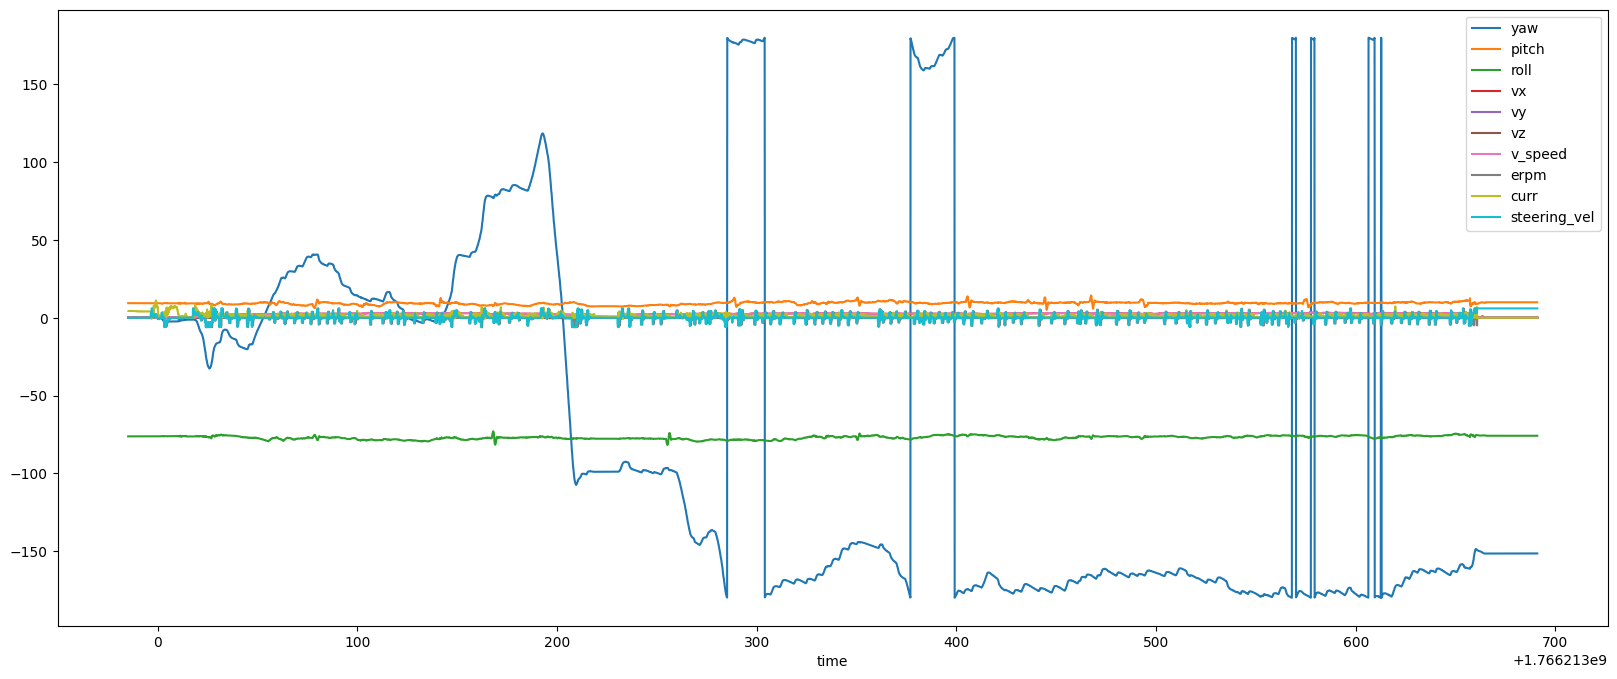

In [150]:
ploting_df = df.copy()
drop_col = ['alt' , 'temp' , 'err' , 'alt','lon','lat','pos']
ploting_df.drop(drop_col, axis=1, inplace=True)
ploting_df.steering_vel = ploting_df.steering_vel/1000
ploting_df.erpm = ploting_df.erpm/1000
ploting_df.plot(kind='line' , figsize=(20,8))

In [151]:
df.describe()

,lat,lon,alt,yaw,pitch,roll,vx,vy,vz,v_speed,pos,erpm,curr,temp,err,steering_vel
count,23624.000000,23624.000000,23624.000000,23624.000000,23624.000000,23624.000000,23624.000000,23624.000000,23624.000000,23624.000000,23623.000000,23623.000000,23623.000000,23623.000000,23623.000000,23622.000000
mean,12.990021,80.226901,-81.055572,-78.155713,9.317206,-76.925768,2.355542,-0.028317,-0.011594,2.363731,0.095236,2.104940,1.273368,56.064619,4.108284,256.391394
std,0.000770,0.003124,1.019650,109.479645,0.879329,1.081376,0.882860,0.067447,0.023138,0.863848,73.642330,1640.434099,1.031540,11.614214,19.762810,2066.451395
min,12.988346,80.223260,-83.432958,-179.967362,5.067474,-81.756077,-0.781200,-0.486700,-0.264900,0.000100,-275.500000,-6190.000000,-1.390000,0.000000,0.000000,-6000.000000
25%,12.989502,80.224210,-81.389100,-168.183238,8.897310,-77.729224,2.358330,-0.051900,-0.020400,2.359697,-15.166667,-100.000000,0.676667,57.000000,0.000000,-112.537500
50%,12.990053,80.226171,-80.600055,-145.570102,9.407892,-76.785630,2.644883,-0.025300,-0.010790,2.645503,-0.250000,0.000000,1.160000,58.000000,0.000000,1.666667
75%,12.990683,80.229251,-80.301034,3.706404,9.852112,-76.090380,2.872400,0.000100,-0.001120,2.872851,0.000000,190.000000,1.713333,59.000000,0.000000,405.481250
max,12.991366,80.233216,-79.884798,179.990558,14.307520,-73.055951,3.411500,0.265200,0.280800,3.413156,428.700012,6130.000000,11.090000,61.000000,100.000000,6000.000000


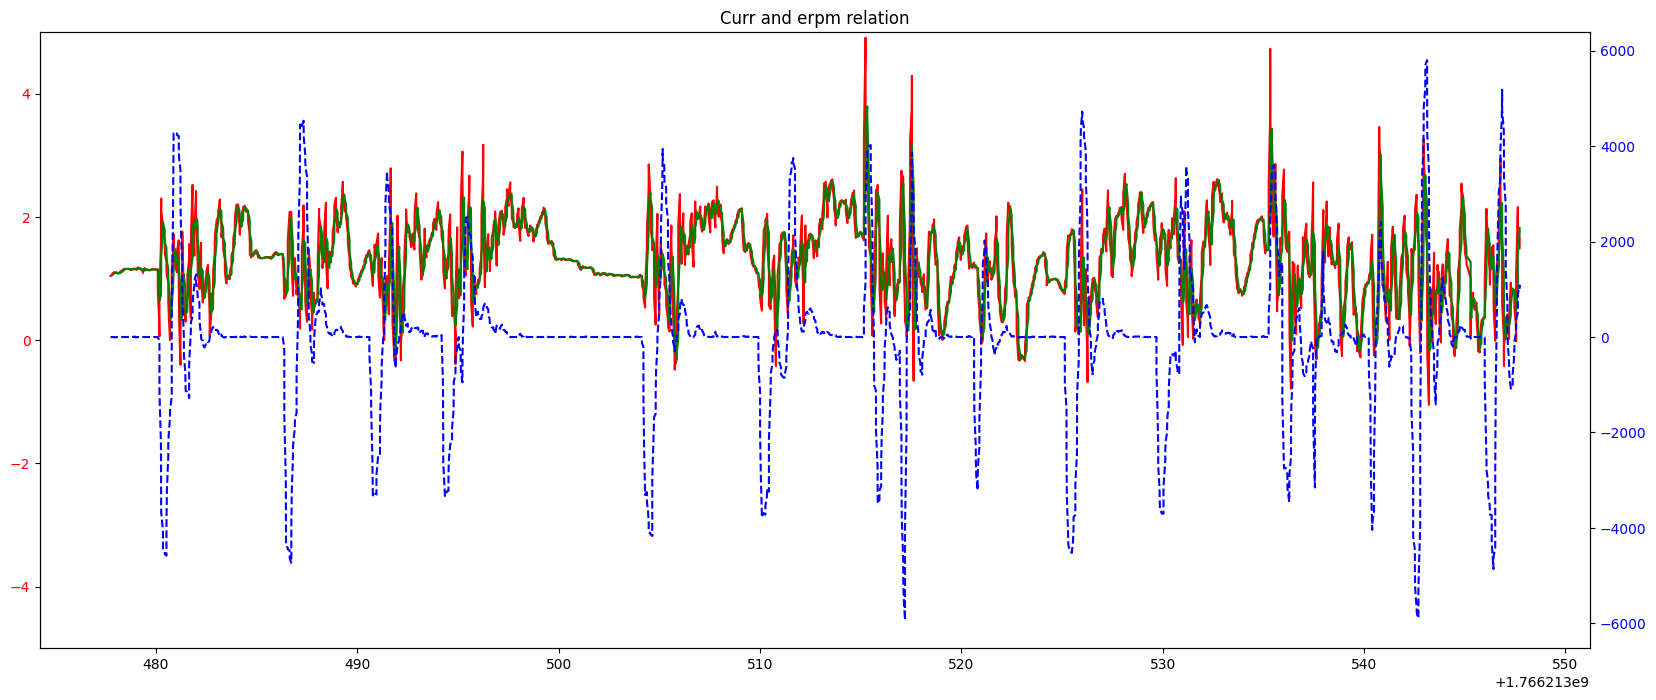

In [182]:
x = df.shape[0]
i = 7
plot_data = df.iloc[int(x*i/10) : int(x*(i+1)/10)]

fig , ax = plt.subplots(figsize=(20,8))
ax2 = ax.twinx()
# Plot data on the first axes (left subplot)
ax.plot(plot_data.curr, 'r-' , label = 'current')
ax.plot(plot_data.curr.rolling(window=5).mean() , 'g' , label = 'rolling current')
ax.set_ylim(-5 , 5)
# Plot data on the second axes (right subplot)
ax2.plot(plot_data.erpm, 'b--' , label= 'erpm')

# 6. Customize tick colors to match the line colors for clarity
ax.tick_params(axis='y', labelcolor='r')
ax2.tick_params(axis='y', labelcolor='b')

# 7. Add a title and show the plot
plt.title('Curr and erpm relation')
plt.show()

In [153]:
cols = ['curr' , 'erpm' , 'yaw']
check_df = df[cols]
check_df['yaw_rate'] = df.yaw.diff().rolling(window=5).mean()
check_df['rpm_rate'] = df.erpm.diff().rolling(window=5).mean()
cov = check_df.corr()
print(cov)

              curr      erpm       yaw  yaw_rate  rpm_rate
curr      1.000000  0.015682  0.091881 -0.006295  0.016158
erpm      0.015682  1.000000  0.002017  0.020966  0.347364
yaw       0.091881  0.002017  1.000000  0.073318 -0.002019
yaw_rate -0.006295  0.020966  0.073318  1.000000  0.016414
rpm_rate  0.016158  0.347364 -0.002019  0.016414  1.000000


There is good yaw to rpm correlation 
current to rpm correlation is lower than to yaw 

In [170]:
# Fitting least square regression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

data = df.dropna(axis=0, how='any')
data = (data - data.mean())/data.std()

y = data.curr
X = data.drop(columns=['curr'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

from sklearn.linear_model import LinearRegression

regressor = LinearRegression().fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

Mean squared error: 1.41
Coefficient of determination: -1.48


In [171]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

data = df.dropna(axis=0, how='any')
data = (data - data.mean())/data.std()

y = data.curr
X = data.drop(columns=['curr'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

print(f"shape of train {X_train.shape}  test {X_test.shape}")
pls2 = PLSRegression(n_components=4)
pls2.fit(X_train, y_train)
PLSRegression()
y_pred = pls2.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

shape of train (16535, 15)  test (7087, 15)
Mean squared error: 1.09
Coefficient of determination: -0.91


## Should fit a tree algorithm and understand feature importances 

In [175]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz , plot_tree
import graphviz
import re

data = df.dropna(axis=0, how='any')
cols = ['temp' , 'lat' , 'lon', 'err']
data.drop(columns=cols , inplace=True)
# data = (data - data.mean())/data.std()

y = data.curr
X = data.drop(columns=['curr'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = DecisionTreeRegressor(criterion= 'squared_error' ,max_depth =10).fit(X_train , y_train ) 

y_pred = model.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

Mean squared error: 0.76
Coefficient of determination: -0.26


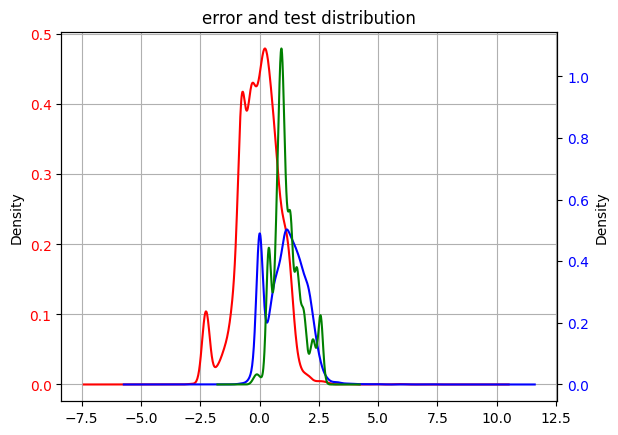

In [176]:
fig , ax = plt.subplots()
ax1 = ax.twinx()

(y_test-y_pred).plot(kind='kde' , ax=ax , label='error' , color='red' , grid=True)
y_test.plot(kind='kde' , ax=ax1 , label = 'test' , color='blue' )

y_pred = pd.Series(y_pred)
y_pred.plot(kind='kde' , ax=ax1 , label = 'pred' , color='green' )

ax.tick_params(axis='y', labelcolor='r')
ax1.tick_params(axis='y', labelcolor='b')
# 7. Add a title and show the plot
plt.title('error and test distribution')
plt.show()

In [159]:
def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

# draw_tree(model , X_train)

In [177]:

for i in range(len(X_train.columns)):
    print(f"{X_train.columns[i]}    :   {model.feature_importances_[i]}")

alt    :   0.024841511774857643
yaw    :   0.024527657923440246
pitch    :   0.28621381417487757
roll    :   0.048847502089748834
vx    :   0.024385522352826403
vy    :   0.007498954195136219
vz    :   0.0092389611290194
v_speed    :   0.3176919931030579
pos    :   0.09437279862534251
erpm    :   0.11006332252672796
steering_vel    :   0.05231796210496533


<Axes: xlabel='time'>

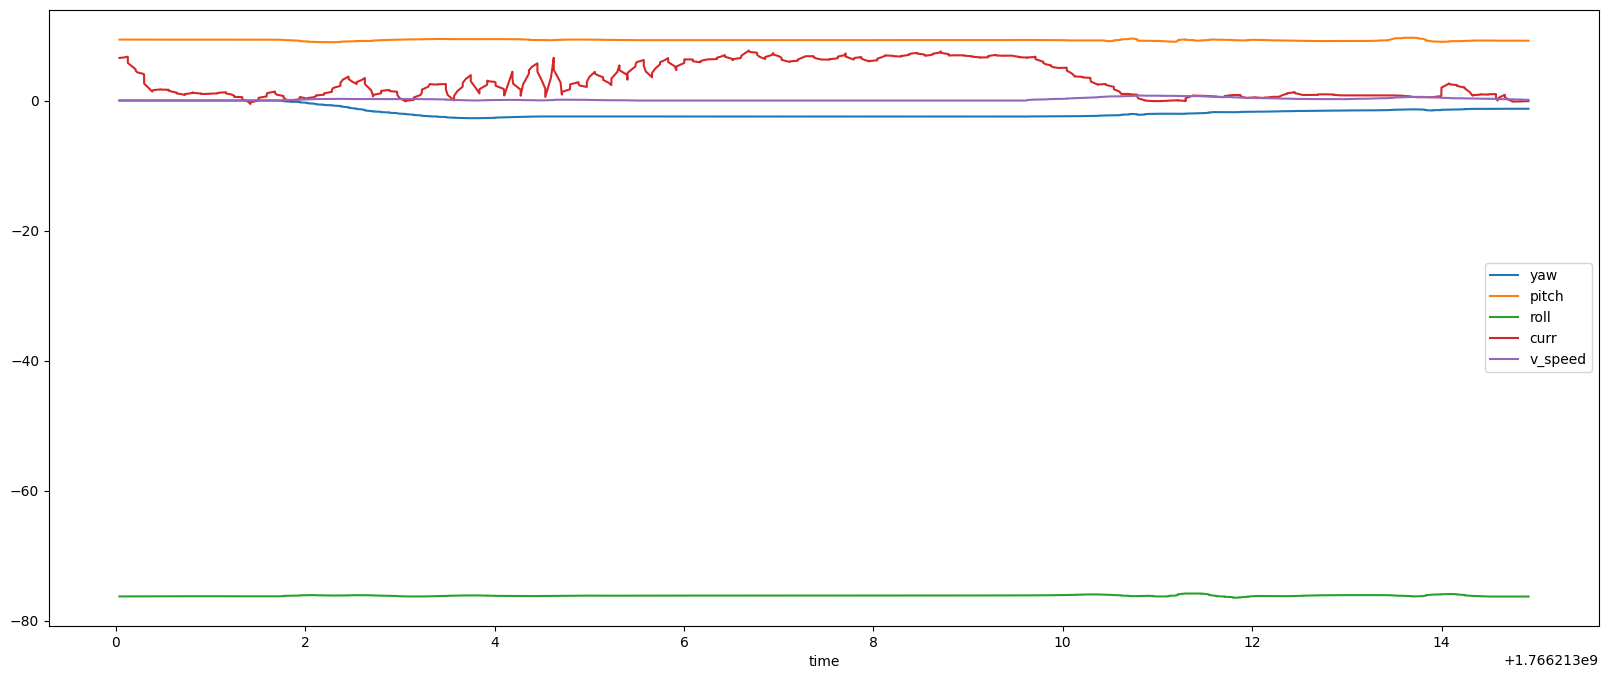

In [161]:
to_view = ['yaw' , 'pitch' , 'roll' , 'curr' , 'v_speed']
ploting_df = df[to_view]
ploting_df.iloc[500:1000].plot(kind='line' , figsize=(20,8))